# Where's the Best Place to Sell Books Online?
The e-commerce platform Flipkart hit an all-important milestone in 2018.
After beating out the world's largest online business, Amazon, for holding the top position in India's online retail market, the startup was acquired for by Wal-Mart for $18B USD.

It is commonly believed that startups can beat out larger businesses through differentiation, or being unique.

Will a machine learning classifier show us the differences between books being sold on Amazon vs. Flipkart?

# Setup for Data Analysis and ML Classifications

In [205]:
# Exploratory Data Analysis libraries
import pandas as pd
import numpy as np
# visualizations
import seaborn as sns 
# run Matplotlib graphs inline in notebook
import matplotlib.pyplot as plt  
%matplotlib inline
# Machine Learning libraries 
import sklearn
from sklearn.model_selection import train_test_split  # function used in building ML models

### Instantiating pandas DataFrames

In [206]:
amazon_df = pd.read_csv('Data/amazon.csv')
flipkart_df = pd.read_csv('Data/flipkart.csv')
# View the data for book listings on Amazon
amazon_df.head()

,amazon_title,amazon_author,amazon_rating,amazon_reviews count,amazon_isbn-10,amazon_price
0,Tell Me your Dreams,by Sidney Sheldon,4.4,160.0,8172234902,209
1,The Boy in the Striped Pyjamas (Definitions),by John Boyne,4.6,134.0,1862305277,350
2,Romancing the Balance Sheet: For Anyone Who Ow...,by Anil Lamba,4.5,156.0,9350294311,477
3,Mossad,by Michael Bar-Zohar - Import,4.6,637.0,8184958455,340
4,My Story,by Kamala Das,4.5,42.0,8172238975,178


In [207]:
# do the same for Flipkart books sold
flipkart_df.head()

,flipkart_author,flipkart_isbn10,flipkart_title,flipkart_ratings count,flipkart_price,flipkart_stars
0,Sidney Sheldon,8172234902,TELL ME YOUR DREAMS,902,209,4.5
1,,1862305277,The Boy in the Striped Pyjamas,83,372,4.5
2,Anil Lamba,9350294311,ROMANCING THE BALANCE SHEET,352,477,4.5
3,Bar-Zohar Michael,8184958455,Mossad,560,280,4.5
4,Kamala Das,8172238975,MY STORY,322,178,4.3


## Fixing Data Inconsistencies

Several problems with the data have been identified, as it pertains to this analysis:

1. Columns are named differently across DataFrames
2. The columns are ordered differently across DataFrames
3. Books with the same title have different casing across DataFrames
4. Data type for ratings count is all floats on Amazon data, yet integers for the analogous column on the Flipkart Dataframe.
5. ISBN columns offers seeminly useless information.
6. Different kinds of NaN values exist in the author columns on both DataFrames (i.e. "By NA", "Not Available", or just leaving the cell empty).
7. Prices are missing the proper decimal point.

### Normaling Prices

In [208]:
# Assumes that prices were listed originally in USD
amzn_prices = amazon_df['amazon_price']
amazon_df['amazon_price'] = [price/100 for price in amzn_prices]

fp_prices = flipkart_df['flipkart_price']
flipkart_df['flipkart_price'] = [price/100 for price in fp_prices]

### Making Column Names Consistent

In [209]:
def cutoff_prefix(df, prefix_length):
    '''Removes the first prefix_length characters from each column in a DataFrame.'''
    col_names = list(df.columns)
    for i in range(len(col_names)):
        # slicing off the first 7 letters
        label = col_names[i]
        col_names[i] = label[prefix_length:]
    # swap out the names in the df for their shortened versions
    new_df = df
    new_df.columns = col_names
    return new_df

# Store new Dataframes whose column names have been shorted
amzn_df = cutoff_prefix(amazon_df, 7)
fp_df = cutoff_prefix(flipkart_df, 9)

### Combining Data into One

**The Ratings/Reviews Count Column**

As I continue pre-processing data, there are a few things to keep in mind. For one thing, there is no contextual benefit in providing the number of reviews as a floating point number, as opposed to an integer. Therefore, I will convert all the floating point values in the "reviews count" column of the Amazon DataFrame to integer values.

In [210]:
# do the ratings/reviews columns have the same number of values to begin with?
print(len(amzn_df['reviews count']) == len(fp_df['ratings count']))
# let's make sure that both reviews count columns have the same number of non-Nan values
print(len(amzn_df['reviews count'].dropna().values) == len(fp_df['ratings count'].dropna().values))

True
False


In [211]:
# alright, so which df has more values?
print(len(amzn_df['reviews count'].dropna().values))
print(len(fp_df['ratings count'].dropna().values))

1378
1382


Okay, so as a heads-up I will need to fill in some NaN values in the Amazon Dataframe!
Here, I decided to fill in using '0.0'.

In [212]:
amzn_df['reviews count'] = amzn_df['reviews count'].fillna('0.0')

In [213]:
# int conversion
review_counts = list()
for count in amzn_df['reviews count']:
    # removing commas
    # print(count)
    if ',' in count:
        count_ls = [char for char in count if char != ',']
        count = ''.join(count_ls)
    review_counts.append(int(float(count)))                             
    
# replacing the column in the DataFrame
amzn_df['reviews count'] = review_counts

Cool! That was way more complicated than expected. 

**Handling NaN Values + Mismatching Column Naming**

For future reference, how about we cross-inspect of all the columns from both DataFrames, so we can:

1. Take note of where differences in column-naming may be an issue,
2. Take note of where Nan values may be an issue,
3. Decide how best to resolve that issues in the context of that column!

In [214]:
amzn_df.columns

Index(['title', 'author', 'rating', 'reviews count', 'isbn-10', 'price'], dtype='object')

In [215]:
fp_df.columns

Index(['author', 'isbn10', 'title', 'ratings count', 'price', 'stars'], dtype='object')

Interesting! It looks like I need to resolve a naming conflict in Flipkart's DataFrame, for the following columns:

- 'stars'
- 'ratings count'

I chose to do this by simply renaming these columns to their Amazonian counterparts. The ISBN columns were simply dropped from both DataFrames, because they will not be used in the analysis to come.

In [216]:
# Renaming Flipkart columns mismatched names
fp_df = fp_df.rename(columns={
    'stars': 'rating',
    'ratings count': 'reviews count'
})
# Removing the ISBN columns of both DataFrames
del amzn_df['isbn-10']
del fp_df['isbn10']

To make the for-loop in the next cell functional, I must first resolve the naming conflict between 'reviews count' and 'ratings count', and likewise for 'review.'

In [217]:
# I assume that with NaN values included, both DataFrames are already the same length.
for col in amzn_df.columns:
    # skipping rating and reviews, since we already did that
    if col != 'reviews count':
        num_valid_rows_am = len(amzn_df[col].dropna().values)
        num_valid_rows_fp = len(fp_df[col].dropna().values)
        print(f"For '{col}', Amazonian data shows {num_valid_rows_am} values, and Flipkart data shows {num_valid_rows_fp} values.")

For 'title', Amazonian data shows 1382 values, and Flipkart data shows 1382 values.
For 'author', Amazonian data shows 1382 values, and Flipkart data shows 1382 values.
For 'rating', Amazonian data shows 1378 values, and Flipkart data shows 1382 values.
For 'price', Amazonian data shows 1382 values, and Flipkart data shows 1382 values.


It looks like we almost match up... except Amazon is lacking 4 non-NaN values in its 'rating' column. This is reasonable, because presumably these were the same rows in which the values for 'reviews count' were also missing.

As before I will in those NaN values with '0.0', with the rationale being:
1. That is what they most likely were, if they were missing during the stage of actually collecting the data;
2. Ratings for books tend to depend on the book's quality; so it would not make sense to use another technique such as GMM for instance, because the value a book gets for its rating should arguably treated as an individual value. That is to say, it should not be confined to the distribution of rating values for this overall dataset.

In [218]:
amzn_df['rating'] = amzn_df['rating'].fillna('0.0')

**Adding a 'Company' Column**

In preparation of combining the two DataFrames, I will also add a 'Company' column to both, so that we will able to tell which row came from which company once they are all together!

In [219]:
def add_company_col(df, company_name):
    '''Add a column to specify which company through which a book was listed on the Internet.'''
    df['Is_Amazon'] = [company_name for i in range(len(df))]
    
add_company_col(amzn_df, 1)  # 1 is affirmative
add_company_col(fp_df, 0)  # 0 is negative

**Stacking DataFrames on Top of Each Other**

In [220]:
def collect_rows(df1, df2, is_stacked):
    """Make a new DataFrames in which all rows from df1 and df2 are combined into one.
    
       Parameters:
       df1(DataFrame): the DataFrame which the return value will be initialized from, by copying.
       df2(DataFrame): the DataFrame whose rows will be added to the copy.
       is_stacked(bool): specificies whether all the rows of df2 will go beneath all the rows in df1, or if False
                         then the return df will alternate between rows of df1 and df2 in its ordering, i.e. each
                         row from one company's DataFrame will be followed by the row in the other DataFrame for the
                         same book.
                         
      Returns: DataFrame
    
    """
    if is_stacked is True:
         # create an empty DataFrame to hold all the eventual data
        merged = pd.DataFrame(data=None, index=list(range(len(df1) + len(df2))), columns=df1.columns)
        # add all rows in df2 below all rows df1, in order by corresponding columns
        for col in df1.columns:
            # form a new column with both sets of data, one after the other
            new_col = df1[col].append(df2[col], ignore_index=True)
            # add it to the new df
            merged[col] = (new_col)
    else:
        merged = pd.DataFrame(data=None, index=list(range(len(df1) + len(df2))), columns=df1.columns)
        # reorder columns in df2 to match df1
        df2 = df2[df1.columns]
        # iterate through all rows of both df's
        for i in range(len(df1)):
            row1, row2 = df1.iloc[i], df2.iloc[i]
            # add in the rows
            merged = merged.append(row1, ignore_index=True)
            merged = merged.append(row2, ignore_index=True)
        # Not completely clear on why the above causes top half of merged to be NaN, for now I'll just cut it out
        merged = merged.iloc[len(merged) // 2:]
    return merged

all_books_stacked = collect_rows(amzn_df, fp_df, True)
all_books_mixed = collect_rows(amzn_df, fp_df, False)

# Exploratory Data Analysis

## How Similar Are the Distributions of Price, Rating, and Review Counts?
These look like the most promising features to use in training our classifier. Are they noticeably different between the two companies?

#### Which features should be used to train the model?
While on the topic, the "title" and "author" columns will not be used to train the classifier. In the context of an application, where a user would enter in the price their desired price for a book, the title they provide will not actually help the classifer in its decision. Rather, it would merely serve to let the machine know amongst which platforms (or labels for the target class) it can choose amongst.

## Distribution of Prices

Both DataFrames have the same 1,382 books listed. What is the range of prices on both sites?

In [223]:
def determine_range(df, col):
    return df[col].max() - df[col].min()

amzn_price_range = determine_range(amzn_df, 'price')
fp_price_range = determine_range(fp_df, 'price')
print(f'Price range on Amazon: ${amzn_price_range} USD')
print(f'Price range on Flipkart: ${fp_price_range} USD')

Price range on Amazon: $8.94 USD
Price range on Flipkart: $51.71 USD


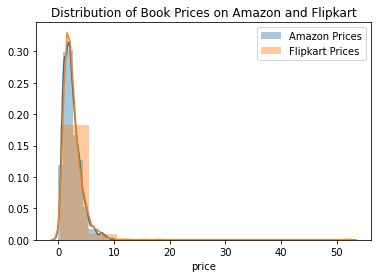

In [227]:
sns.distplot(amzn_df['price'], hist=True, bins=10, kde=True, label='Amazon Prices')
sns.distplot(fp_df['price'], hist=True, bins=10, kde=True, label='Flipkart Prices')
plt.legend()
plt.title('Distribution of Book Prices on Amazon and Flipkart')
plt.show()

### Interesting!
It appears on one hand, the prices of books on Amazon tend to be slighly higher than, and have less variance, than the book prices on Flipkart.